# Analysis of product_range.csv

Since we had 2 datasets to analyze, we attempted to analyze the first one alone. The product_range.csv file describes every product offered by this Russian bar, with variables including: product code, country of origin, vendor code, name of product, ABV, size, retail price, and base unit. We removed categorical variables (country of origin) because there were 20+ countries previously present, and one-hot encoding for all of these countries proved to be a lot of data to work with. We narrowed down to analyzing variables that we believe could influence price, including ABV, size (base unit describes the size in language familiar to the restaurant, while size contains the size in Liters), and retail price.

In [7]:
# import packages and get data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

product_range = pd.read_csv('../data/Product_range.csv')

# Data Filtering - Product_Range
product_range = product_range.drop(columns=['Base_unit'])#,'Country_of_Origin'

# Standardizing columns
product_range['Name'] = product_range['Name'].str.replace('\d+','', regex=True).str.strip('.')

product_range.columns = ['Product_code', 'Vendor', 'Name', 'Price','Country', 'Size', 'ABV']

product_range['Product_code'] = pd.to_numeric(product_range['Product_code'])
product_range['Price'] = pd.to_numeric(product_range['Price'])
product_range['Size'] = pd.to_numeric(product_range['Size'])
product_range['ABV'] = pd.to_numeric(product_range['ABV'])

# Removing missing/NaN
product_range = product_range.dropna()
product_range = product_range.reset_index(drop=True)

# Reducing number of categorical Country variables for 
product_range['Country'] = product_range['Country'].replace(['Denmark', 'United Kingdom', 'Estonia', 'Spain', 'Germany', 'Norway', 'Italy', 'France', '???', 'Ireland', 
                                  'Canada', 'Finland', 'Scotland', 'Japan', 'Latvia', 'Czech', 'Croatia', 'Austria', 'Switzerland', 
                                  'China', 'Brazil', 'Israel'], 'Other')

product_range = pd.get_dummies(product_range, columns = ['Country'])

product_range.head()

,Product_code,Vendor,Name,Price,Size,ABV,Country_Belgium,Country_Netherlands,Country_Other,Country_Russia,Country_Sweden,Country_USA
0,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0
1,1176,3Fonteine,Fonteinen Intense Red Oude Kriek / % /,3300.0,0.750,6.0,1,0,0,0,0,0
2,726,3Fonteine,Fonteinen Oude Geuze / % /,1500.0,0.750,6.0,1,0,0,0,0,0
3,1617,3Fonteine,Fonteinen Oude Geuze / % /,950.0,0.375,5.0,1,0,0,0,0,0
4,4548,3Fonteine,Fonteinen Oude Geuze Assemblage,1100.0,0.375,6.6,1,0,0,0,0,0


After cleaning the data, we plotted a heatmap of the remaining variables and found that none had a strong correlation with each other.

/var/folders/1h/p0yg3zrn74952165spggmcxr0000gn/T/ipykernel_21257/1444340026.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(product_range.corr(),linewidths=0.1, annot=True,cmap='YlGn') #[['Price', 'Size', 'ABV']]


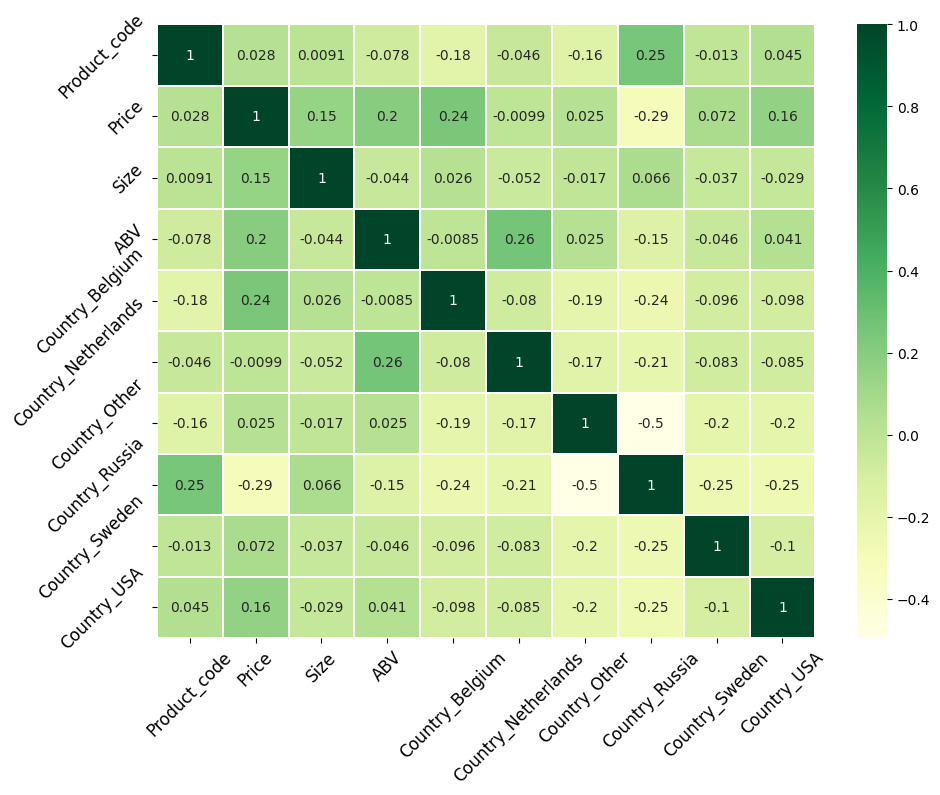

In [8]:
# We can link together the datasets by the product_code in both but that might be messyyyy but we might have to at some point
# Plot relationship between all variables of product_range
plt.figure(figsize=(10, 8))
sns.heatmap(product_range.corr(),linewidths=0.1, annot=True,cmap='YlGn') #[['Price', 'Size', 'ABV']]
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

We ran multiple linear regression on this dataset using an 80% test and a 20% split set, and created a scatterplot demonstrating the predicted labels being compared to the actual labels, in regards to price and with outliers > 2000 removed. It can be difficult to see, but most of the predictions are not close to the actual price or we would see a linear relationship (where predicted price matches actual price). This reinforces that price is dependent on more factors than ABV and size.

Text(0, 0.5, 'Predicted')

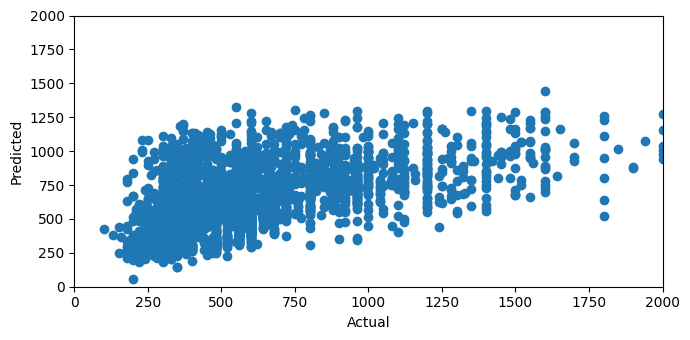

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

split = int(product_range.shape[0]*0.8)

X = product_range[['Product_code', 'Size', 'ABV', 'Country_Belgium', 'Country_Netherlands', 'Country_Other', 'Country_Russia', 
                   'Country_Sweden', 'Country_USA']]
Y = product_range['Price']

X_train, X_test, y_train, y_true = train_test_split(X, Y, test_size = 0.8, random_state = 0)

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.scatter(y_true ,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

Finally, we plotted the results via a 3D model and determined the MSE to be very high - a sign that we needed to consider other variables.

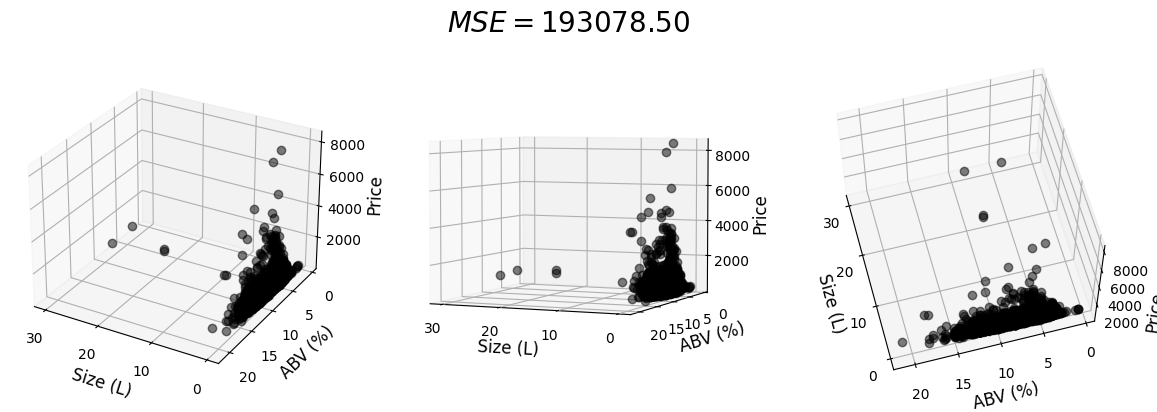

In [10]:
size = X['Size']
abv = X['ABV']
price = Y

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for ax in [ax1, ax2, ax3]:
    ax.plot(size, abv, price, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.set_xlabel('Size (L)', fontsize=12)
    ax.set_ylabel('ABV (%)', fontsize=12)
    ax.set_zlabel('Price', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$MSE = %.2f$' % mean_squared_error(y_true, y_pred), fontsize=20)

fig.tight_layout()

Overall, we did not find our analysis of the product_range.csv file to give us a conclusive result, and also analyzed the transactions dataset. 